<a href="https://colab.research.google.com/github/NesterukSergey/hidden-networks/blob/master/demos/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import argparse
import os
import math
from types import SimpleNamespace
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# !git clone -l -s https://github.com/NesterukSergey/hidden-networks.git cloned-repo
# %cd cloned-repo
# !ls

In [0]:
# import utils
# from utils import *

In [0]:
# %cd ../
# !pwd
# !ls

In [6]:
# Tiny ImageNet
!git clone -l -s https://github.com/seshuad/IMagenet.git tinyimagenet-repo

Cloning into 'tinyimagenet-repo'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.


In [7]:
!ls tinyimagenet-repo

README.md  tiny-imagenet-200  TinyImagenet.ipynb  TinyImagenet.py


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
tiny_imagenet_train_dataset = datasets.ImageFolder('./tinyimagenet-repo/tiny-imagenet-200/train', transform=data_transforms['train'])
tiny_imagenet_test_dataset = datasets.ImageFolder('./tinyimagenet-repo/tiny-imagenet-200/test', transform=data_transforms['val'])
tiny_imagenet_val_dataset = datasets.ImageFolder('./tinyimagenet-repo/tiny-imagenet-200/val', transform=data_transforms['val'])

In [0]:
tiny_imagenet_train_dataloader = torch.utils.data.DataLoader(tiny_imagenet_train_dataset, batch_size=32, shuffle=True, num_workers=8)
tiny_imagenet_test_dataloader = torch.utils.data.DataLoader(tiny_imagenet_test_dataset, batch_size=32, shuffle=False, num_workers=8)
tiny_imagenet_val_dataloader = torch.utils.data.DataLoader(tiny_imagenet_val_dataset, batch_size=32, shuffle=False, num_workers=8)

In [11]:
iter(tiny_imagenet_train_dataloader).next()[0].shape

torch.Size([32, 3, 64, 64])

In [0]:
LearnedBatchNorm = nn.BatchNorm2d

class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

In [0]:
DenseConv = nn.Conv2d

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the subnetwork by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None


# Not learning weights, finding subnet
class SubnetConv(nn.Conv2d):
    def __init__(self, *args, prune_rate=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.set_prune_rate(prune_rate=prune_rate)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate

    @property
    def clamped_scores(self):
        return self.scores.abs()

    def forward(self, x):
        subnet = GetSubnet.apply(self.clamped_scores, self.prune_rate)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x


"""
Sample Based Sparsification
"""


class StraightThroughBinomialSample(autograd.Function):
    @staticmethod
    def forward(ctx, scores):
        output = (torch.rand_like(scores) < scores).float()
        return output

    @staticmethod
    def backward(ctx, grad_outputs):
        return grad_outputs, None


class BinomialSample(autograd.Function):
    @staticmethod
    def forward(ctx, scores):
        output = (torch.rand_like(scores) < scores).float()
        ctx.save_for_backward(output)

        return output

    @staticmethod
    def backward(ctx, grad_outputs):
        subnet, = ctx.saved_variables

        grad_inputs = grad_outputs.clone()
        grad_inputs[subnet == 0.0] = 0.0

        return grad_inputs, None


# Not learning weights, finding subnet
class SampleSubnetConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if parser_args.score_init_constant is not None:
            self.scores.data = (
                torch.ones_like(self.scores) * parser_args.score_init_constant
            )
        else:
            nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

    @property
    def clamped_scores(self):
        return torch.sigmoid(self.scores)

    def forward(self, x):
        subnet = StraightThroughBinomialSample.apply(self.clamped_scores)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

        return x


"""
Fixed subnets 
"""


class FixedSubnetConv(nn.Conv2d):
    def __init__(self, *args, prune_rate=0.3, **kwargs):
        super().__init__(*args, **kwargs)
        self.set_prune_rate(prune_rate=prune_rate)

        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

    def set_prune_rate(self, prune_rate):
        self.prune_rate = prune_rate
        print("prune_rate_{}".format(self.prune_rate))

    def set_subnet(self):
        output = self.clamped_scores().clone()
        _, idx = self.clamped_scores().flatten().abs().sort()
        p = int(self.prune_rate * self.clamped_scores().numel())
        flat_oup = output.flatten()
        flat_oup[idx[:p]] = 0
        flat_oup[idx[p:]] = 1
        self.scores = torch.nn.Parameter(output)
        self.scores.requires_grad = False

    def clamped_scores(self):
        return self.scores.abs()

    def get_subnet(self):
        return self.weight * self.scores

    def forward(self, x):
        w = self.get_subnet()
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

In [0]:
class Builder(object):
    def __init__(self, conv_layer, bn_layer, first_layer=None):
        self.conv_layer = conv_layer
        self.bn_layer = bn_layer
        self.first_layer = first_layer or conv_layer

    def conv(self, kernel_size, in_planes, out_planes, stride=1, first_layer=False):
        conv_layer = self.first_layer if first_layer else self.conv_layer

        if first_layer:
            print(f"==> Building first layer with {str(self.first_layer)}")

        if kernel_size == 3:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False,
            )
        elif kernel_size == 1:
            conv = conv_layer(
                in_planes, out_planes, kernel_size=1, stride=stride, bias=False
            )
        elif kernel_size == 5:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=5,
                stride=stride,
                padding=2,
                bias=False,
            )
        elif kernel_size == 7:
            conv = conv_layer(
                in_planes,
                out_planes,
                kernel_size=7,
                stride=stride,
                padding=3,
                bias=False,
            )
        else:
            return None

        self._init_conv(conv)

        return conv

    def conv3x3(self, in_planes, out_planes, stride=1, first_layer=False):
        """3x3 convolution with padding"""
        c = self.conv(3, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv1x1(self, in_planes, out_planes, stride=1, first_layer=False):
        """1x1 convolution with padding"""
        c = self.conv(1, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv7x7(self, in_planes, out_planes, stride=1, first_layer=False):
        """7x7 convolution with padding"""
        c = self.conv(7, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def conv5x5(self, in_planes, out_planes, stride=1, first_layer=False):
        """5x5 convolution with padding"""
        c = self.conv(5, in_planes, out_planes, stride=stride, first_layer=first_layer)
        return c

    def batchnorm(self, planes, last_bn=False, first_layer=False):
        return self.bn_layer(planes)

    def activation(self):
        if args.nonlinearity == "relu":
            return (lambda: nn.ReLU(inplace=True))()
        else:
            raise ValueError(f"{args.nonlinearity} is not an initialization option!")

    def _init_conv(self, conv):
        if args.init == "signed_constant":

            fan = nn.init._calculate_correct_fan(conv.weight, args.mode)
            if args.scale_fan:
                fan = fan * (1 - args.prune_rate)
            gain = nn.init.calculate_gain(args.nonlinearity)
            std = gain / math.sqrt(fan)
            conv.weight.data = conv.weight.data.sign() * std

        elif args.init == "unsigned_constant":

            fan = nn.init._calculate_correct_fan(conv.weight, args.mode)
            if args.scale_fan:
                fan = fan * (1 - args.prune_rate)

            gain = nn.init.calculate_gain(args.nonlinearity)
            std = gain / math.sqrt(fan)
            conv.weight.data = torch.ones_like(conv.weight.data) * std

        elif args.init == "kaiming_normal":

            if args.scale_fan:
                fan = nn.init._calculate_correct_fan(conv.weight, args.mode)
                fan = fan * (1 - args.prune_rate)
                gain = nn.init.calculate_gain(args.nonlinearity)
                std = gain / math.sqrt(fan)
                with torch.no_grad():
                    conv.weight.data.normal_(0, std)
            else:
                nn.init.kaiming_normal_(
                    conv.weight, mode=args.mode, nonlinearity=args.nonlinearity
                )

        elif args.init == "kaiming_uniform":
            nn.init.kaiming_uniform_(
                conv.weight, mode=args.mode, nonlinearity=args.nonlinearity
            )
        elif args.init == "xavier_normal":
            nn.init.xavier_normal_(conv.weight)
        elif args.init == "xavier_constant":

            fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(conv.weight)
            std = math.sqrt(2.0 / float(fan_in + fan_out))
            conv.weight.data = conv.weight.data.sign() * std

        elif args.init == "standard":

            nn.init.kaiming_uniform_(conv.weight, a=math.sqrt(5))

        else:
            raise ValueError(f"{args.init} is not an initialization option!")


def get_builder():

    print("==> Conv Type: {}".format(args.conv_type))
    print("==> BN Type: {}".format(args.bn_type))

    conv_layer = SubnetConv
    bn_layer = NonAffineBatchNorm

    if args.first_layer_type is not None:
        first_layer = getattr(conv_type, args.first_layer_type)
        print(f"==> First Layer Type: {args.first_layer_type}")
    else:
        first_layer = None

    builder = Builder(conv_layer=conv_layer, bn_layer=bn_layer, first_layer=first_layer)

    return builder

In [0]:
# BasicBlock {{{
class BasicBlock(nn.Module):
    M = 2
    expansion = 1

    def __init__(self, builder, inplanes, planes, stride=1, downsample=None, base_width=64):
        super(BasicBlock, self).__init__()
        if base_width / 64 > 1:
            raise ValueError("Base width >64 does not work for BasicBlock")

        self.conv1 = builder.conv3x3(inplanes, planes, stride)
        self.bn1 = builder.batchnorm(planes)
        self.relu = builder.activation()
        self.conv2 = builder.conv3x3(planes, planes)
        self.bn2 = builder.batchnorm(planes, last_bn=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.bn1 is not None:
            out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        if self.bn2 is not None:
            out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


# BasicBlock }}}

# Bottleneck {{{
class Bottleneck(nn.Module):
    M = 3
    expansion = 4

    def __init__(self, builder, inplanes, planes, stride=1, downsample=None, base_width=64):
        super(Bottleneck, self).__init__()
        width = int(planes * base_width / 64)
        self.conv1 = builder.conv1x1(inplanes, width)
        self.bn1 = builder.batchnorm(width)
        self.conv2 = builder.conv3x3(width, width, stride=stride)
        self.bn2 = builder.batchnorm(width)
        self.conv3 = builder.conv1x1(width, planes * self.expansion)
        self.bn3 = builder.batchnorm(planes * self.expansion, last_bn=True)
        self.relu = builder.activation()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        out = self.relu(out)

        return out


# Bottleneck }}}

# ResNet {{{
class ResNet(nn.Module):
    def __init__(self, builder, block, layers, num_classes=1000, base_width=64):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.base_width = base_width
        if self.base_width // 64 > 1:
            print(f"==> Using {self.base_width // 64}x wide model")

        if args.first_layer_dense:
            self.conv1 = nn.Conv2d(
                3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False
            )
        else:
            self.conv1 = builder.conv7x7(3, 64, stride=2, first_layer=True)

        self.bn1 = builder.batchnorm(64)
        self.relu = builder.activation()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(builder, block, 64, layers[0])
        self.layer2 = self._make_layer(builder, block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(builder, block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(builder, block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        if args.last_layer_dense:
            self.fc = nn.Conv2d(512 * block.expansion, args.num_classes, 1)
        else:
            self.fc = builder.conv1x1(512 * block.expansion, num_classes)

    def _make_layer(self, builder, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            dconv = builder.conv1x1(
                self.inplanes, planes * block.expansion, stride=stride
            )
            dbn = builder.batchnorm(planes * block.expansion)
            if dbn is not None:
                downsample = nn.Sequential(dconv, dbn)
            else:
                downsample = dconv

        layers = []
        layers.append(block(builder, self.inplanes, planes, stride, downsample, base_width=self.base_width))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(builder, self.inplanes, planes, base_width=self.base_width))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        if self.bn1 is not None:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = x.view(x.size(0), -1)

        return x


# ResNet }}}

In [0]:
def ResNet18(pretrained=False):
    return ResNet(get_builder(), BasicBlock, [2, 2, 2, 2], 1000)


def ResNet50(pretrained=False):
    return ResNet(get_builder(), Bottleneck, [3, 4, 6, 3], 1000)

In [0]:
def freeze_model_weights(model):
    print("=> Freezing model weights")

    for n, m in model.named_modules():
        if hasattr(m, "weight") and m.weight is not None:
            print(f"==> No gradient to {n}.weight")
            m.weight.requires_grad = False
            if m.weight.grad is not None:
                print(f"==> Setting gradient of {n}.weight to None")
                m.weight.grad = None

            if hasattr(m, "bias") and m.bias is not None:
                print(f"==> No gradient to {n}.bias")
                m.bias.requires_grad = False

                if m.bias.grad is not None:
                    print(f"==> Setting gradient of {n}.bias to None")
                    m.bias.grad = None


def freeze_model_subnet(model):
    print("=> Freezing model subnet")

    for n, m in model.named_modules():
        if hasattr(m, "scores"):
            m.scores.requires_grad = False
            print(f"==> No gradient to {n}.scores")
            if m.scores.grad is not None:
                print(f"==> Setting gradient of {n}.scores to None")
                m.scores.grad = None


def unfreeze_model_weights(model):
    print("=> Unfreezing model weights")

    for n, m in model.named_modules():
        if hasattr(m, "weight") and m.weight is not None:
            print(f"==> Gradient to {n}.weight")
            m.weight.requires_grad = True
            if hasattr(m, "bias") and m.bias is not None:
                print(f"==> Gradient to {n}.bias")
                m.bias.requires_grad = True


def unfreeze_model_subnet(model):
    print("=> Unfreezing model subnet")

    for n, m in model.named_modules():
        if hasattr(m, "scores"):
            print(f"==> Gradient to {n}.scores")
            m.scores.requires_grad = True


In [0]:
# Default args
# Some temporary are redundant
args = {
    'data': '/mnt/disk1/datasets',
    'optimizer': 'sgd',
    'set': 'ImageNet',
    'arch': 'ResNet18',
    'log-dir': None,
    'workers': 20,
    'epochs': 90,
    'start-epoch': None,
    'batch-size': 256,
    'learning-rate': 0.1,
    'warmup_length': 0,
    'weight-decay': 1e-4,
    'print-freq': 10,
    'num_classes': 200,
    'resume': '',
    'pretrainde': None,
    'seed': None,
    'multigpu': None,
    'lr-policy': 'constant_lr',
    'multistep-lr-adjust': 30,
    'multistep-lr-gamma': 0.1,
    'name': None,
    'prune-rate': 0.0,
    'low-data': 1,
    'nesterov': False,
    'conv_type': None,
    'conv-type': None,
    'mode': 'fan_in',
    'nonlinearity': 'relu',
    'bn-type': None,
    'init': 'kaiming_normal',
    'no-bn-decay': False,
    'scale-fan': False,
    'label-smoothing': None,
    'first-layer-type': None,
    'trainer': 'default',
    'score-init-constant': None,
    'bn_type': NonAffineBatchNorm,
    'conv_type': SubnetConv,
    'freeze_weights': True,
    'first_layer_type': None,
    'first_layer_dense': None,
    'scale_fan': None,
    'last_layer_dense': True,
    
}

args = SimpleNamespace(**args)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
class Denormalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.demean = [-m/s for m, s in zip(mean, std)]
        self.std = std
        self.destd = [1/s for s in std]
        self.inplace = inplace

    def __call__(self, tensor):
        tensor = TF.normalize(tensor, self.demean, self.destd, self.inplace)
        # clamp to get rid of numerical errors
        return torch.clamp(tensor, 0.0, 1.0)

In [0]:
def show_batch(dataloader):
    fig, ax = plt.subplots(1, dataloader.batch_size, sharex=True, sharey=True, figsize=(20, 10))
    img_batch, label = iter(dataloader).next()
    
    denormalize = Denormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  
    
    print(label.numpy())
    for i in range(dataloader.batch_size):                                
        ax[i].imshow(transforms.ToPILImage()(denormalize(img_batch[i, :, :, :])))

[113  84 123 123 126 198  46  23 144  30   2 187 164 138 197 126  95  10
 148  74 109 151 154  72 120  17   0  79 137 108  90 134]


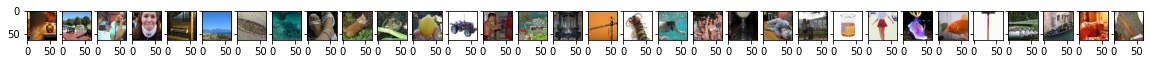

In [25]:
show_batch(tiny_imagenet_train_dataloader)

In [0]:
def train(model, device, train_loader, optimizer, criterion, epoch, verbose=False):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss

        if verbose:
          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))
              
    return train_loss / len(train_loader.dataset)


def test(model, device, criterion, test_loader):
    true_labels = []
    predictions = [] # labels
    outputs = [] # probabilities

    model.eval()
    test_loss = 0
    # correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target)
            outputs.append(output.detach().cpu().numpy())
            pred = output.argmax(dim=1, keepdim=True)

            predictions.extend(pred)
            true_labels.extend(target.detach().cpu().numpy())
            # correct += pred.eq(target.view_as(pred)).sum().item()

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    outputs = np.array(outputs)

    test_loss /= len(test_loader.dataset)
    test_accuracy = np.sum(np.equal(predictions, true_labels)) / len(true_labels)
    
    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        # test_loss, correct, len(test_loader.dataset),
        # 100. * correct / len(test_loader.dataset)))
    
    return test_loss.item(), test_accuracy

In [27]:
model = ResNet18().to(device)
optimizer = optim.Adam(
      [p for p in model.parameters() if p.requires_grad],
      lr=5e-3,
      weight_decay=0.0005,
  )
criterion = nn.CrossEntropyLoss().to(device)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2, verbose=True, min_lr=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=40)

==> Conv Type: <class '__main__.SubnetConv'>
==> BN Type: <class '__main__.NonAffineBatchNorm'>
==> Building first layer with <class '__main__.SubnetConv'>


In [0]:
%%time

train_losses = []
test_losses = []
test_acc = []

for epoch in tqdm(range(30)):
    train_loss = train(model, device, tiny_imagenet_train_dataloader, optimizer, criterion, epoch, verbose=False)
    test_loss, test_accuracy = test(model, device, criterion, tiny_imagenet_test_dataloader)
    scheduler.step()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(range(len(train_losses)), train_losses, label='Train loss')
ax[0].plot(range(len(train_losses)), test_losses, label='Test loss')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(range(len(train_losses)), test_acc)
ax[1].set_title('Accuracy (on test)')

plt.show()

print('Test loss: ', test_losses[-1])
print('Train accuracy: ', test_acc[-1])